<a href="https://colab.research.google.com/github/rafabenevente/AM_1/blob/main/AM_1_Titanic_Predi%C3%A7%C3%A3o_dos_sobreviventes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Titanic: Predição dos Sobreviventes com Machine Learning
===

# Conhecendo o Conjunto de Dados


**Dicionário**

|Variável |Definição|Chave|
|:---- |----|----:|
|survival  | Sobrevivente |0 = Não, 1 = Sim|
|pclass |Classe da ticket| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex  |Sexo| 	
|Age  | Idade em anos| 	
|sibsp| # de irmãs / cônjuges a bordo do Titanic |
|parch |# de pais / crianças a bordo do Titanic |	
|ticket| ID do ticket| 	
|fare 	|Tarifa de passageiro (libra esterlina)| 	
|cabin 	|número da cabine| 	
|embarked |Porto de embarcação|C = Cherbourg, Q = Queenstown, S = Southampton|


**Observações**
- pclass: Status socieconômico
    - 1st = Alta
    - 2nd = Média
    - 3rd = Baixa
- age: A idade é fracionária se menor que 1. Se a idade for estimada, é na forma de xx.5

- sibsp: O conjunto de dados define as relações familiares desta forma ...
    - Sibling = irmão, irmã, meio-irmão, meia-irmã
    - Spouse = marido, esposa (amantes e noivos foram ignorados)

- parch: O conjunto de dados define as relações familiares desta forma ...
    - Parent = mãe, pai
    - Child = filha, filho, enteada, enteado
    - Algumas crianças viajavam apenas com a babá, portanto parch = 0 para elas.



## Importação e características

In [72]:
test_url = 'https://raw.githubusercontent.com/rafabenevente/AM_1/main/test.csv'
train_url = 'https://raw.githubusercontent.com/rafabenevente/AM_1/main/train.csv'
validation_url = 'https://raw.githubusercontent.com/galvaowesley/MachineLearning_Learning/master/Titanic%20-%20Suvivors%20Classification/gender_submission.csv'

# Importa as bibliotecas de cálculo e manipulação de dados
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sns


In [73]:
# Carregamento daa base de dados inicialmente separada em treino e teste
train = pd.read_csv(train_url)
test =  pd.read_csv(test_url)

In [6]:
# Dimensão da base de dados
print("Treino tem {} linhas e {} colunas \n". format(train.shape[0], train.shape[1]))
print("Teste tem {} linhas e {} colunas \n". format(test.shape[0], test.shape[1]))

Treino tem 891 linhas e 12 colunas 

Teste tem 418 linhas e 11 colunas 



Há, portanto, 1309 linhas ao total. O conjunto de dados original sofreu split na proporção: 68% para treino e 32% para teste. 

In [7]:
# Aparência do train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Tipo de dados das variáveis
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Análise Exploratória dos Dados

Função para automatizar o agrupamento de duas variáveis categóricas e gera uma visualização do relacionamento de ambas com contagem e percentual. 

In [10]:
# Fonte: https://stackoverflow.com/questions/63745343/annotate-percentage-of-group-within-a-seaborn-countplot
def barPlotPercent(df, atributo1, atributo2):
  '''
  Função que recebe um dataframe e dois atributos categóricos, realiza o agrupamento 
  de ambos e mostra a contagem e percentual do atributo1 em função do atributo2. 
  '''

  # prepare the dataset
  df = (df
        .groupby([atributo1, atributo2])
        .size()
        .reset_index()
        #.replace({"Survived": {0:"no", 1:"yes"}})
        .rename(columns={0:"count"}))

  # Calcula o percentual do atributo2 % por níveis do atributo1.
  df["percent"] = (df
                  .groupby(atributo1)
                  .apply(lambda x: x["count"] / x["count"].sum()).values)

  # sort the dataframe to match the drawing order
  df.sort_values(by=[atributo2, atributo1], inplace=True)

  # Visualização
  plt.style.use('ggplot')
  fig = sns.catplot(
    x="count", y=atributo1, hue=atributo2,
    kind="bar", data=df, height=4, aspect=2)

  for i, bar in enumerate(fig.ax.patches):
    
      height = bar.get_height()
      fig.ax.annotate(
          # reference the pre-calculated row in the dataframe
          f"{df.iloc[i, 3] :.0%}",
          xycoords="data",
          xytext=(20, -15),
          textcoords="offset points",
          xy=(bar.get_width(), bar.get_y()),
          ha='center', va='center')

  # make space for annonations
  plt.margins(x=0.2)
  plt.show()

## Sobreviventes

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Survived')

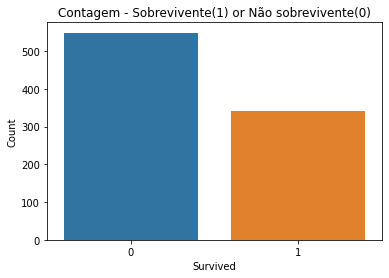

In [11]:
# Contagem de sobreviventes e não sobreviventes
plt.title("Contagem - Sobrevivente(1) or Não sobrevivente(0)")
sns.countplot(train.Survived)
plt.ylabel("Count")
plt.xlabel("Survived")

## Gênero

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Survived')

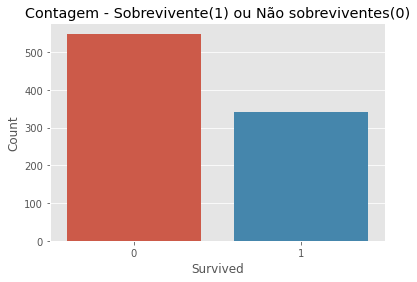

In [19]:
# Contagem de sobreviventes e não sobreviventes
plt.title("Contagem - Sobrevivente(1) ou Não sobreviventes(0)")
sns.countplot(train.Survived)
plt.ylabel("Count")
plt.xlabel("Survived")

In [13]:
# Sumarização de Survived por gênero
train.groupby(['Survived', 'Sex'])['Sex'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64

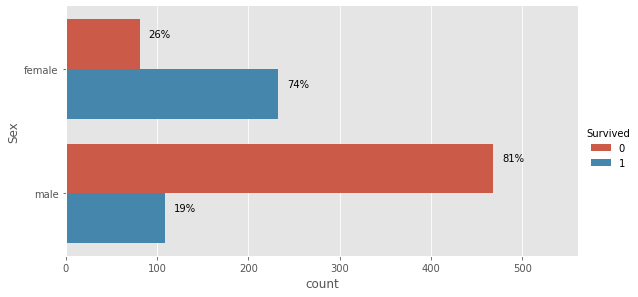

In [14]:
# Visualização de Survived por gênero
barPlotPercent(train, 'Sex', 'Survived')

## Classe Social (Pclass)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Pclass')

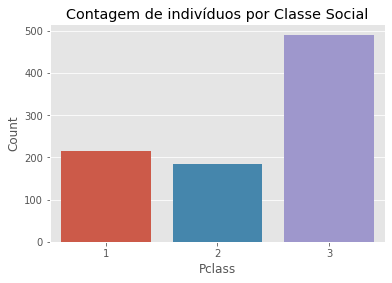

In [15]:
# Contagem de passageiros por Classe Social
plt.title("Contagem de indivíduos por Classe Social")
sns.countplot(train.Pclass)
plt.ylabel("Count")
plt.xlabel("Pclass")

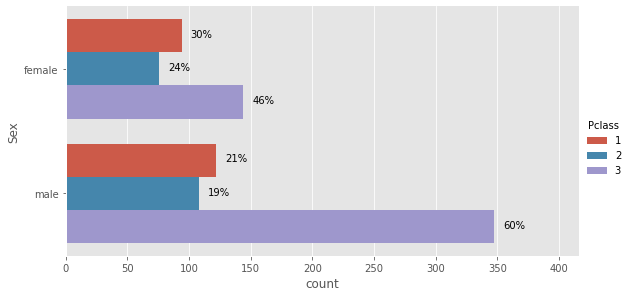

In [20]:
# Percentual e contagem de indivíduos por Classe Social e sexo
barPlotPercent(train, 'Sex', 'Pclass')

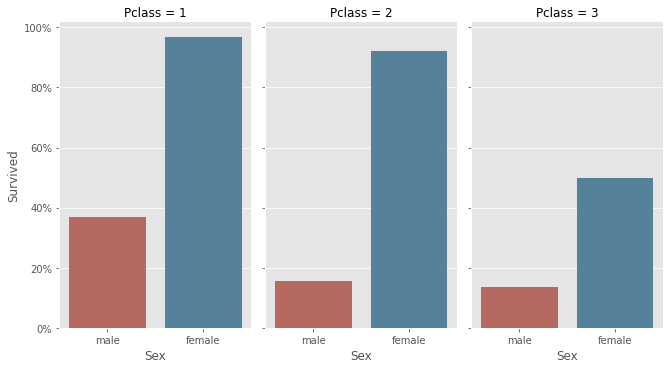

In [24]:
# Percentual de sobreviventes por sexo e classe social
#Fonte: https://stackoverflow.com/questions/52512790/python-seaborn-catplot-how-do-i-change-the-y-axis-scale-to-percentage
g = sns.catplot(x="Sex", y="Survived", col="Pclass",
                 data=train, saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

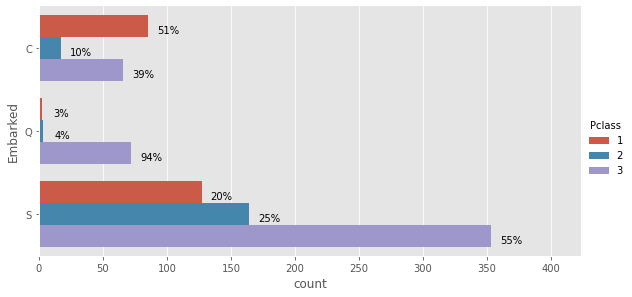

In [16]:
# Visualização de Classe Social por Porto de Embarcação
barPlotPercent(train, 'Embarked', 'Pclass')

## Idade

In [70]:
# Sumário de idade
train.Age.describe()


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

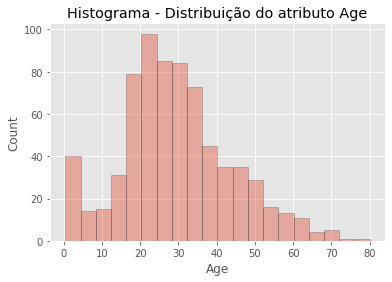

In [63]:
plt.title("Histograma - Distribuição do atributo Age")
sns.distplot(a=train['Age'], kde = False, hist_kws = {'edgecolor':'black'})
plt.ylabel("Count")

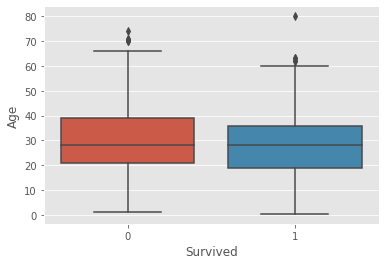

In [74]:
#Boxplot Survived x Age
sns.boxplot(x='Survived', y='Age', data=train)
plt.show()

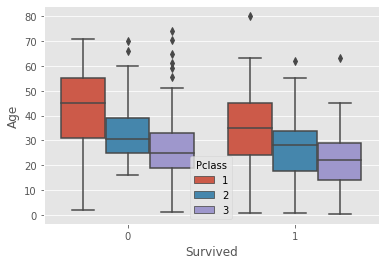

In [93]:
#Boxplot Survived x Age agrupados pela Pclass
sns.boxplot(x='Survived', y='Age', data=train, hue='Pclass')

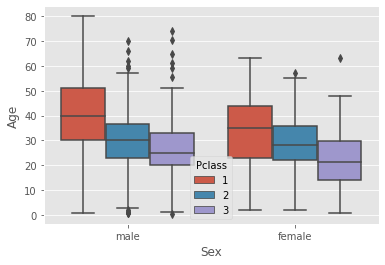

In [94]:
#Boxplot Sex x Age agrupados pela Pclass

sns.boxplot(x='Sex', y='Age', data=train, hue='Pclass')

## Correlação entre variáveis

Explorando o nível de correlação entre as variáveis.

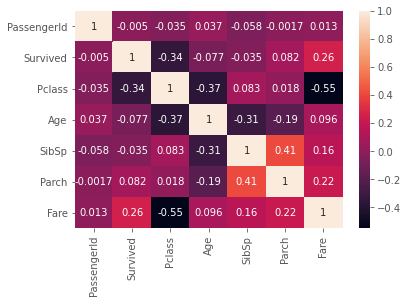

In [18]:
# Heatmap de coeficiente de correlação entre as variáveis
sns.heatmap(train.corr(), annot = True)

# Engenharia de atributos



## Junção dos datasets de treino e teste

In [25]:
print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

# salvar os índices dos datasets para recuperação posterior
train_idx = train.shape[0]
test_idx = test.shape[0]

# salvar PassengerId para submissao ao Kaggle
passengerId = test['PassengerId']

# extrair coluna 'Survived' e excluir ela do dataset treino
train_Y = train.Survived.copy()
train.drop(['Survived'], axis=1, inplace=True)

# concatenar treino e teste em um único DataFrame
all_data = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

print(f"All_data shape {all_data.shape}")

Train shape (891, 12)
Test shape (418, 11)
All_data shape (1309, 11)


## Imputação de dados ausentes

In [26]:
# age
age_median = all_data['Age'].median()
all_data['Age'].fillna(age_median, inplace=True)

# fare
fare_median = all_data['Fare'].median()
all_data['Fare'].fillna(fare_median, inplace=True)

# embarked
embarked_top = all_data['Embarked'].value_counts()[0]
all_data['Embarked'].fillna(embarked_top, inplace=True)

## Remoção de colunas e preparação de variaveis

In [27]:
# Remoção de colunas que não serão usadas
all_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Preparação de variaveis
all_data['Sex'] = all_data['Sex'].map({'male': 0, 'female': 1})

# Criação de dummies
embarked_dummies = pd.get_dummies(all_data['Embarked'], prefix='Embarked')
all_data = pd.concat([all_data, embarked_dummies], axis=1)
all_data.drop('Embarked', axis=1, inplace=True)

## Separação dos datasets

In [28]:
train_X = all_data.iloc[:train_idx]
print(train.shape)
test = all_data.iloc[train_idx:]
print(test.shape)

from sklearn.model_selection import train_test_split
# Separação treino e teste
tr_x, te_x, tr_y, te_y = train_test_split(train_X, train_Y,
                                            test_size = 0.2,
                                            random_state=42,
                                            stratify=train_Y)

(891, 11)
(418, 10)


# Modelos de predição

##  Arvore de decisão

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}
dtc = DecisionTreeClassifier()
gs = GridSearchCV(dtc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                

### Predição e avaliação do modelo

In [30]:
# Melhores parametros apontados pelo grid search
dtc = gs.best_estimator_

dtc.fit(tr_x, tr_y)
y_pred = dtc.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.770949720670391


[[100  10]
 [ 31  38]]


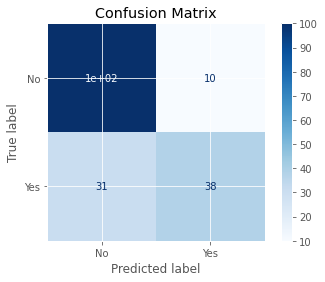

In [31]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(dtc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## K-Neighbors Classifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(1,15,2),
              'metric': ['euclidean', 'manhattan']}

knc = KNeighborsClassifier()
gs = GridSearchCV(knc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 15, 2),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [33]:
# Melhores parametros apontados pelo grid search
knc = gs.best_estimator_

knc.fit(tr_x, tr_y)
y_pred = knc.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.7206703910614525


[[88 22]
 [28 41]]


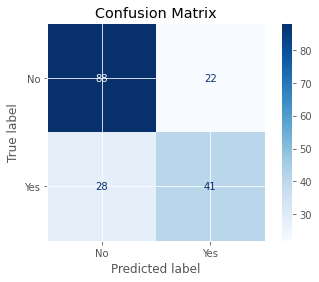

In [34]:
disp = plot_confusion_matrix(knc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## SVM

In [ ]:
from sklearn.svm import NuSVC
param_grid = {'nu': np.linspace(0,1,5),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'decision_function_shape' : ['ovo', 'ovr']}

svc = NuSVC()
gs = GridSearchCV(svc, param_grid=param_grid)
gs.fit(tr_x, tr_y)

### Predição e avaliação do modelo

In [ ]:
# Melhores parametros apontados pelo grid search
svc = gs.best_estimator_

svc.fit(tr_x, tr_y)
y_pred = svc.predict(te_x)
print(accuracy_score(te_y, y_pred))

In [ ]:
disp = plot_confusion_matrix(svc, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Naive Bayes

In [42]:
from sklearn.naive_bayes import MultinomialNB
param_grid = {'alpha': np.linspace(0,2,5),
              'fit_prior': [False,True]}

mnb = MultinomialNB()
gs = GridSearchCV(mnb, param_grid=param_grid)
gs.fit(tr_x, tr_y)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0. , 0.5, 1. , 1.5, 2. ]),
                         'fit_prior': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predição e avaliação do modelo

In [43]:
# Melhores parametros apontados pelo grid search
mnb = gs.best_estimator_

mnb.fit(tr_x, tr_y)
y_pred = mnb.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.6480446927374302


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


[[87 23]
 [40 29]]


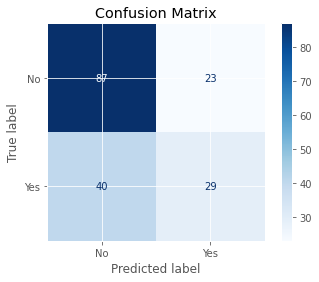

In [44]:
disp = plot_confusion_matrix(mnb, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'dual': [False,True],
              'fit_intercept': [False,True],
              'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

lr = LogisticRegression()
gs = GridSearchCV(lr, param_grid=param_grid)
gs.fit(tr_x, tr_y)

### Predição e avaliação do modelo

In [46]:
# Melhores parametros apontados pelo grid search
lr = gs.best_estimator_

lr.fit(tr_x, tr_y)
y_pred = lr.predict(te_x)
print(accuracy_score(te_y, y_pred))

0.7988826815642458


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[97 13]
 [23 46]]


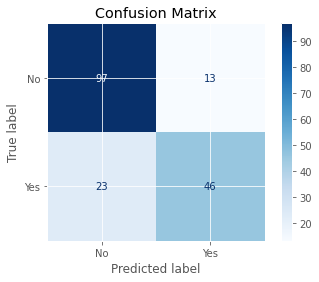

In [47]:
disp = plot_confusion_matrix(lr, te_x, te_y,
                                 display_labels=["No", "Yes"],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

# Referências

* [Kaggle Competition - Titanic: Machine Learning from Disaster ](https://www.kaggle.com/c/titanic)
* [Kaggle Notebook - Titanic Tutorial](https://www.kaggle.com/alexisbcook/titanic-tutorial)
* [Kaggle Notebook - Titanic Survival Prediction](https://www.kaggle.com/vaishnavikhilari/titanic-survival-prediction#3.-Imputation-of-Missing-Data/-Outliers)
* [Kaggle Notebook - Survivors Classification on Titanic using R](https://www.kaggle.com/galvaowesley/survivors-classification-on-titanic-using-r)
* [Tutorial: Introduction to Missing Data Imputation](https://medium.com/@Cambridge_Spark/tutorial-introduction-to-missing-data-imputation-4912b51c34eb)
* [Different Ways to Compensate for Missing Values In a Dataset (Data Imputation with examples ](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)
* [Titanic: Machine Learning from Disaster](https://github.com/carlosfab/data_science/blob/master/Titanic.ipynb)
* [Scikit-Learn Documentation](https://scikit-learn.org/stable/index.html)